In [1]:
# Importing libraries
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as scp
import random as rd
import scipy.stats
import matplotlib.pyplot as plt
from IPython.display import display
from sympy.interactive import printing
printing.init_printing(use_latex=True)

# The generalized logistic (Richards), skewnormal and generalized gamma functions
def richards(p):
    def aux(x):
        return p[0]*(1+1/p[2])*((1+p[2])/(1+p[0]*np.exp(-p[1]*x)))**(1/p[2])/(p[0]+np.exp(p[1]*x))
    return aux

def skewnormal(p):
    def aux(x):
        return np.exp(-(x-p[0])**2/(2*p[1]**2))/(np.sqrt(2*np.pi)*p[1])*(1+(scp.special.erf(p[2]*(x-p[0])/p[1])/np.sqrt(2)))
    return aux

def gengamma(p):
    def aux(x):
        return np.abs(x)**(p[0]-1)*np.exp(-(np.abs(x)/p[1])**p[2])
    def aux2(x):
        return aux(x)/aux(p[1]*((p[0]-1)/p[2])**(1/p[2]))
    return aux2

# Maximum entropy models
def maxent(p):
    def aux(x):
        return np.exp((np.sqrt(np.abs(p[0]))+np.sqrt(np.abs(p[1])))**2-p[0]/x-p[1]/(1-x))
    return aux

def beta(p):
    def aux(x):
        return x**(p[0]-1)*(1-x)**(p[1]-1)/scp.special.beta(p[0], p[1])
    def aux2(x):
        return aux(x)/aux((p[0]-1)/(p[0]+p[1]-2))
    return aux2

# Normalizing interval to suit specific model
def int_norm(dom, bounds):
    a = np.min(dom)
    b = np.max(dom)
    eps = 5e-4
    A = bounds[0]+eps
    B = bounds[1]-eps
    m = (B-A)/(b-a)
    n = (b*A-a*B)/(b-a)
    return dom*m+n

# Root-mean squared optimization objective
def obj(data):
    def mdl(fit):
        def dom(itv):
            def par(p):
                return np.sqrt(np.mean((data-fit(p)(itv))**2))
            return par
        return dom
    return mdl

In [2]:
import warnings
warnings.filterwarnings('ignore')
p0 = [1, 1, 1]
int_r = np.linspace(-20, 20, 100)
int_m = np.linspace(0, 1, 100)
int_g = np.linspace(0, 10, 100)
results = {}
for f in ['Richards', 'Skewnormal', 'GenGamma', 'Maxent', 'Beta']:
    print('Using ', f, ' to model ')
    for g in ['Richards', 'Skewnormal', 'GenGamma', 'Maxent', 'Beta']:
        print(g, end=' ')
        results[(f, g)] = []
        n = 0
        while (n < 1e3):
            mls = {'Richards': [lambda p: richards(p), [rd.uniform(0.25, 4), rd.uniform(0.25, 4), rd.uniform(0.25, 4)], int_r, [-5, 5]],
                   'Skewnormal': [lambda p: skewnormal(p), [rd.uniform(0, 4), rd.uniform(1, 4), rd.uniform(-4, 4)], int_r, [-5, 5]],
                   'GenGamma': [lambda p: gengamma(p), [rd.uniform(2, 6), rd.uniform(2, 6), rd.uniform(2, 6)], int_g, [0, 5]],
                   'Maxent': [lambda p: maxent(p), [rd.uniform(0.25, 4), rd.uniform(0.25, 4)], int_m, [0, 1]],
                   'Beta': [lambda p: beta(p), [rd.uniform(1.25, 5), rd.uniform(1.25, 5)], int_m, [0, 1]]}
            data = mls[g][0](mls[g][1])(mls[g][2])
            data = data/np.max(data)
            res = scp.optimize.minimize(obj(data)(mls[f][0])(int_norm(mls[g][2], mls[f][3])), p0)
            results[(f, g)].append(res.fun)
            #print(n, ' ', res.fun, end='  ')
            n+=1
        results[(f, g)] = np.array(results[(f, g)])[~np.isnan(results[(f, g)])]
        print(f"{np.mean(results[(f, g)]):.2}", f"({np.std(results[(f, g)]):.2})", end = ' ')
    print()

Using  Richards  to model 
Richards 0.0021 (0.013) Skewnormal 0.036 (0.067) GenGamma 0.055 (0.08) Maxent 0.041 (0.013) Beta 0.07 (0.058) 
Using  Skewnormal  to model 
Richards 0.12 (0.07) Skewnormal 0.072 (0.043) GenGamma 0.26 (0.11) Maxent 0.28 (0.058) Beta 0.47 (0.07) 
Using  GenGamma  to model 
Richards 0.32 (0.092) Skewnormal 0.33 (0.034) GenGamma 0.36 (0.15) Maxent 0.43 (0.1) Beta 0.32 (0.25) 
Using  Maxent  to model 
Richards 0.028 (0.02) Skewnormal 0.026 (0.014) GenGamma 0.064 (0.1) Maxent 0.0017 (0.028) Beta 0.058 (0.11) 
Using  Beta  to model 
Richards 0.036 (0.022) Skewnormal 0.025 (0.019) GenGamma 0.031 (0.017) Maxent 0.011 (0.0052) Beta 0.0013 (0.0029) 


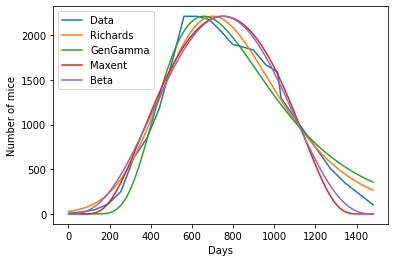

In [3]:
df = pd.read_csv("universe25.csv", names = ['time', 'number']).sort_values(by=['time'])
dt = 1/8
ts = np.arange(df['time'].iloc[0],  df['time'].iloc[-1], dt)
number =  np.interp(ts, df['time'], df['number'])
fit = {}
mls = {'Richards': [lambda p: richards(p), [rd.uniform(0.25, 4), rd.uniform(0.25, 4), rd.uniform(0.25, 4)], int_r, [-5, 5]],
       'Skewnormal': [lambda p: skewnormal(p), [rd.uniform(0, 4), rd.uniform(1, 4), rd.uniform(-4, 4)], int_r, [-5, 5]],
       'GenGamma': [lambda p: gengamma(p), [rd.uniform(2, 6), rd.uniform(2, 6), rd.uniform(2, 6)], int_g, [0, 5]],
       'Maxent': [lambda p: maxent(p), [rd.uniform(0.25, 4), rd.uniform(0.25, 4)], int_m, [0, 1]],
       'Beta': [lambda p: beta(p), [rd.uniform(1.25, 5), rd.uniform(1.25, 5)], int_m, [0, 1]]}
data = number/np.max(number)
plt.plot(ts, number, label='Data')
for f in ['Richards', 'GenGamma', 'Maxent', 'Beta']:
    res = scp.optimize.minimize(obj(data)(mls[f][0])(int_norm(ts, mls[f][3])), p0)
    fit[f] = [res.fun, res.x]
    plt.plot(ts, np.max(number)*mls[f][0](res.x)(int_norm(ts, mls[f][3])), label=f)
plt.legend(loc = 'upper left')
plt.xlabel('Days')
plt.ylabel('Number of mice')
plt.savefig('1.pdf')

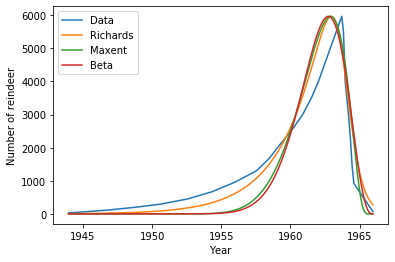

In [4]:
df = pd.read_csv("stmatthew.csv", names = ['time', 'number']).sort_values(by=['time'])
dt = 1/8
ts = np.arange(df['time'].iloc[0],  df['time'].iloc[-1], dt)
number =  np.interp(ts, df['time'], df['number'])
fit = {}
p0 = [1, 1, 1]
data = number/np.max(number)
plt.plot(ts, number, label='Data')
for f in ['Richards', 'Maxent']:
    res = scp.optimize.minimize(obj(data)(mls[f][0])(int_norm(ts, mls[f][3])), p0)
    fit[f] = [res.fun, res.x]
    plt.plot(ts, np.max(number)*mls[f][0](res.x)(int_norm(ts, mls[f][3])), label=f)
res = scp.optimize.minimize(obj(data)(beta)(int_norm(ts, [0, 1])), [20, 5])
plt.plot(ts, np.max(number)*beta(res.x)(int_norm(ts, [0, 1])), label='Beta')
plt.legend(loc = 'upper left')
plt.xlabel('Year')
plt.ylabel('Number of reindeer')
plt.savefig('2.pdf')